# Using the NICER Background Estimator

Author: Mike Corcoran (michael.f.corcoran@nasa.gov)

NICER events contain background events due to optical loading (which generally affects the spectrum at channels lower than channel 40) and particle background (which generally dominates at channels higher than channel 800).  These background components can vary during an observation.  NICER events also contain background from cosmic sources in the NICER field of view.  

A spectrum accumulated over a given time interval is affected by background conditions during that interval. There are at least three parameters that can be used to estimate the total background during that interval:
* the sun angle - this helps predict the amount of optical loading.
* the cut-off rigidity - observations at low values of cut-off rigidity (<3, say) may be affected by charged particle background than observations at high values of cut-off rigidity.
* the kP value - this is a parameter that characterizes the space weather conditions; high KP values indicate a higher charged particle space weather environment. Charged particle background is highest at high KP and low cut-off rigidity

The ``nicergof.bkg`` package uses an ["enhanced" background events file](https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nicer/xti/pcf/30nov18targskc_enhanced.evt) created from "blank sky" observations (i.e. fields with no known X-ray sources within the NICER field of view, and was accumulated from the RXTE background fields observed by NICER  (up through November 2018). This file also includes  KP, COR_SAX and SUN_ANGLE values appropriate for the time for each event in the file.  

The ``nicergof.bkg`` package  also uses the [``kp.fits``](https://heasarc.gsfc.nasa.gov/FTP/caldb/data/gen/pcf/kp.fits) file (which is a FITS version created from the the [NOAA input data](ftp://ftp.swpc.noaa.gov/pub/indices/old_indices).

Assume a spectrum has been accumulated from NICER events for a target for some set of Good Time Intervals. The background is estimated, for each GTI used to accumulate the spectrum:
* Hierarchically creating a histogram of bins of of KP/COR_SAX/SUN_ANGLE values 
* extracting events from the background event file which match the observed KP, SUN_ANGLE and COR_SAX bin range 
* determining the amount of time the background events was in that particular (KP, SUN_ANGLE, COR_SAX) bin, 
* correcting the background exposure time for deadtime
* and finally scaling the background (which include data from 50 FPMs)  by the number of Focal Plane Modules (FPMs) used to extract the source spectrum

# CAVEATS

* This software is still under development, so there are significant caveats.  
* There may be combinations of (KP, COR_SAX, SUN_ANGLE) which are not contained in the background events file; in this case these times are ignored in the output background spectrum.  Keith and I are working on an update to this events file, and eventually plan to automate creation of this file (which will be available through the NICER website or the CALDB - plans still have firmed up).
* there may be other parameters that are important in determining background; this is still under investigation
* there are undoubtedly other issues.  If found please send an email to nicerhelp@bigbang.gsfc.nasa.gov 

# ``bk.mk_bkg_spec_evt`` Docstring:


ip> from nicergof.bkg import bkg_estimator as be

ip> ``be?``

```
This package contains functions which can be used to create an estimated NICER background spectrum based on the "environmental" model
developed by the NICER Guest Observer Facility. The environmental model uses a combination of the cut-off rigidity (COR_SAX)
and the Planetary K index (KP) which gives an estimate of the space weather environment.  This model also uses the SUN_ANGLE parameter
which helps describe the low-energy background produced by optical loading.  COR_SAX and SUN_ANGLE are contained in the
"make filter" file (either the standard auxil/ni*.mkf file distributed with processed data or -recommended- the augmented MKF file produced by
the "niprefilter2" tool distributed with the NICERDAS HEASoft package).  The KP values are not currently included in either the .mkf or the
enhanced (.mkf2) makefilter files, and must be added using the add_kp function defined here.

PRELIMINARIES:

You'll need access to these files:
    a) The background events file 30nov18targskc_enhanced.evt (current version: https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nicer/xti/pcf/30nov18targ
skc_enhanced.evt)
    b) the KP.fits file (the current version, updated daily, is at https://heasarc.gsfc.nasa.gov/FTP/caldb/data/gen/pcf/kp.fits)
You can access these files virtually by specifying the URLs given above (the default for the functions defined below) or
you can download them to a local directory for faster access.

EXAMPLE of creating an estimated NICER background spectrum:

  Assumptions:
  - the NICER data is stored in subdirectories of a root directory called "testdata" of the current working directory.
  - the NICER observation obsid is 1200040103
  - a extracted spectrum (which contains background) is called src.pha and is located in the current working directory.
  - a NICER make filter file created using the niprefilter2 NICERDAS tool exists.
```

# USAGE

This package depends on other (mostly standard) python packages as shown by the imports below.  Users should ensure they have, 
in particular,  ``astropy`` and ``pandas`` installed.  

In [2]:
# Imports

import numpy as np
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.time import Time
import os
import pandas as pd
import glob
from matplotlib.pyplot import *

from nicergof.bkg import bkg_estimator as be

print('Done with imports')


Done with imports


# Unit Test

An example calculation can be seen in the unit_test which is part of the package. A sample run is shown below:

In [71]:
# Change rootdir to point to the location of the testdata directory distributed with nicergof.bkg
rootdir = '/path/to/testdata'
rootdir = 'testdata'
# then run 
bkg_chan, bkgspec_tot, bexpotot = be.unit_test(pha='test.pha', obsid=1200040103,root='testdata', numfpms = 52,
                                               bevt="https://heasarc.gsfc.nasa.gov/FTP/caldb/data/nicer/xti/pcf/30nov18targskc_enhanced.evt"):

Making mkf3 file ./1200040103/auxil/ni1200040103.mkf3
Writing ./1200040103/auxil/ni1200040103.mkf3
Making Background Spectrum

For GTI #0; Duration = 1285.9678901433945

KP: expo = 829.5384631223776; dur of GTI = 1285.9678901433945
KP: % of bkg events between 2 < kp < 3 = 24.22%
COR: expo = 208.42475171497728; dur of GTI = 1285.9678901433945
COR: % of bkg events between 2 < COR < 3 = 3.06%
Done COR index 1; 2 < COR < 3
    SA: expo = 0.019166529669166987; dur of GTI = 1285.9678901433945
    for 90<Sun Angle<100; Number of Events=4696
    Done SUN Angle index 5; 90 < SUN_ANGLE < 100; # Events = 4696
    Source exposure = 0.019; Background exposure = 2979.440
    SA: expo = 0.09712230215827339; dur of GTI = 1285.9678901433945
    for 100<Sun Angle<110; Number of Events=3642
    Done SUN Angle index 6; 100 < SUN_ANGLE < 110; # Events = 3642
    Source exposure = 0.097; Background exposure = 2312.930
    SA: expo = 0.09712230215827339; dur of GTI = 1285.9678901433945
    for 110<Sun Angle<


 Writing ./test_bkg.pha
Done


# Compare the Calculated Background with the Source Spectrum

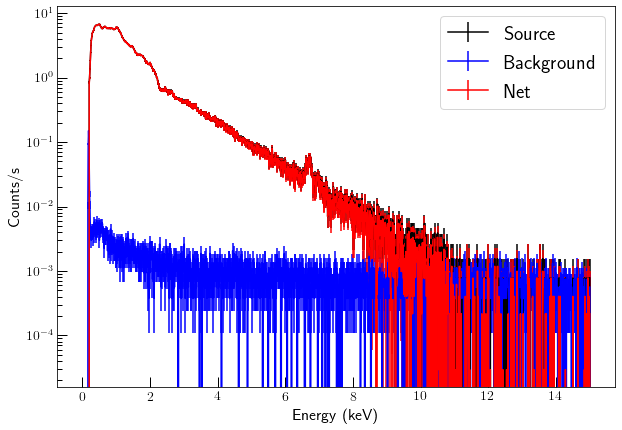

In [3]:
%matplotlib inline

pha='test.pha'
hdup=fits.open(pha)
hdub=fits.open(pha.replace('.pha','_bkg.pha'))
sch = hdup['SPECTRUM'].data['CHANNEL']
sct = hdup['SPECTRUM'].data['COUNTS']
se = hdup['SPECTRUM'].header['EXPOSURE']
bch = hdup['SPECTRUM'].data['CHANNEL']
bct = hdub['SPECTRUM'].data['COUNTS']
bex = hdub['SPECTRUM'].header['EXPOSURE']
figure(figsize=[10,7])
yscale('log')
xlabel('Energy (keV)', fontsize=16)
ylabel('Counts/s', fontsize=16)
errorbar(sch/100, sct/se, yerr=np.sqrt(sct)/se, label='Source')
errorbar(bch/100, bct/bex, yerr=np.sqrt(bct)/bex,label='Background')
errorbar(bch/100, sct/se - bct/bex, yerr=np.sqrt(sct)/se,label='Net')
legend(loc='upper right', fontsize=20)
